In [2]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "../../../gnode/experiment_analysis/dat/"

2023-10-09 17:20:27,311 | INFO     | notebook | <module> | project directory: /Users/paul/para/2_Projects/information_timescales/repo/_latest/experiment_analysis


In [3]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_all.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2023-10-09 17:20:33,515 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'image_selectivity_ns'] from /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2023-10-09 17:20:33,519 | DEBUG    | its_utility | load_metrics | Matched 12807 rows from meta_df in /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723


In [4]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")

2023-10-09 17:20:38,221 | DEBUG    | notebook | <module> | dropping 417 rows with too large timescales
2023-10-09 17:20:38,705 | DEBUG    | plot_helper | fancy_violins | 3.0 median: 1.6762 quantiles: [1.66462299 1.6889493 ] from 500 samples of length 5309
2023-10-09 17:20:38,705 | DEBUG    | plot_helper | fancy_violins | 3.0 min: 0.28 max: 3.2
2023-10-09 17:20:39,183 | DEBUG    | plot_helper | fancy_violins | 8.0 median: 1.6856 quantiles: [1.67519623 1.6955268 ] from 500 samples of length 5706
2023-10-09 17:20:39,184 | DEBUG    | plot_helper | fancy_violins | 8.0 min: 0.28 max: 3
2023-10-09 17:20:39,667 | DEBUG    | plot_helper | fancy_violins | null median: 1.7152 quantiles: [1.70334435 1.73405567] from 500 samples of length 5782
2023-10-09 17:20:39,667 | DEBUG    | plot_helper | fancy_violins | null min: 0.28 max: 2.9
2023-10-09 17:20:39,679 | DEBUG    | plot_helper | fancy_violins | plotting 1200 points for cat block


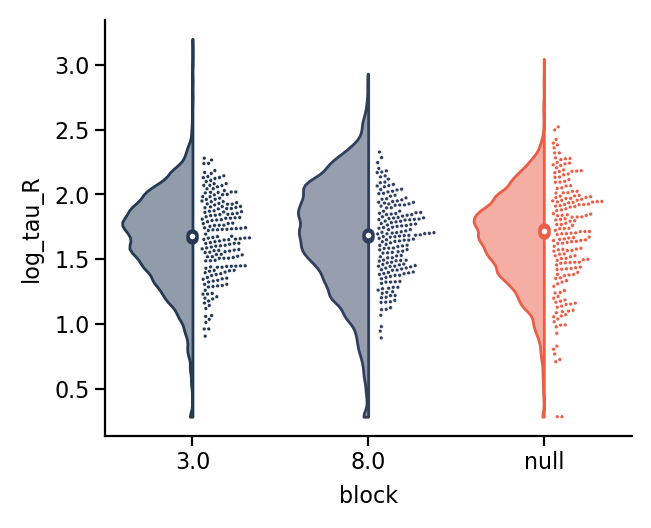

In [5]:
ph.log.setLevel("DEBUG")


df = meta_df.query(
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')) | " + 
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)

obs = "tau_R"

df[f"log_{obs}"] = df.apply(lambda row: np.log10(row[obs] * 1000), axis=1)

if "tau" in obs:
    # everything above 10s is unrealistic
    num_dropped = len(df.query(f"({obs} > 10) | ({obs} <= 0)"))
    log.debug(f"dropping {num_dropped} rows with too large timescales")
    df = df.query(f"({obs} <= 1000) & ({obs} > 0.00)")

# this is a paired sample thing, only take units that have both stimuli
# fiund the intersection of units that exist in both stimuli
units = set(
    df.query("stimulus == 'spontaneous'")["unit_id"]
).intersection(set(df.query("stimulus == 'natural_movie_one_more_repeats'")["unit_id"]))
df = df.query("unit_id in @units")

ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"log_{obs}",
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "3.0" : "#233954",
        "8.0" : "#2F3F5F",
        "null" : "#EA5E48",
    },  
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)

2023-10-09 17:20:39,984 | INFO     | notebook | <module> | r: -0.052, p: 4.3e-05, m: -0.024, b: 0.059


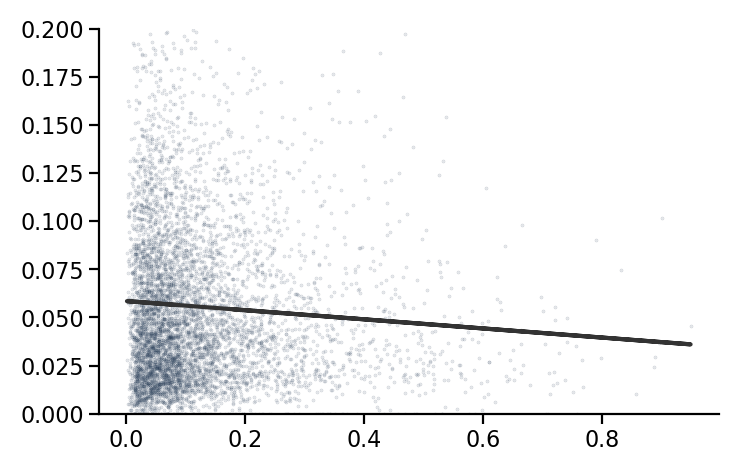

In [6]:
import scipy.stats

df = meta_df.query("stimulus == 'natural_movie_three' & block == '3.0'")
df = df.query("(tau_double <= 10) & (tau_double > 0)")

obs = "tau_R"
df = df.query(f"{obs} == {obs}")
df = df.query("g_dsi_dg == g_dsi_dg")
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.scatter(df["g_dsi_dg"], df[obs], s=0.1, alpha=0.2);
ax.set_ylim(0, 0.2)
# ax.set_xscale("log")

r , p_val = scipy.stats.pearsonr(df["g_dsi_dg"], df[obs])
m, b = np.polyfit(df["g_dsi_dg"], df[obs], 1)

log.info(f"r: {r:.3f}, p: {p_val:.2g}, m: {m:.3f}, b: {b:.3f}")
ax.plot(df["g_dsi_dg"], m*df["g_dsi_dg"] + b, color = ".2")


In [7]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy: 1.11.1

scipy         : 1.11.1
matplotlib    : 3.7.2
pandas        : 2.0.3
xarray        : 2023.7.0
logging       : 0.5.1.2
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
sqlite3       : 2.6.0
prompt_toolkit: 3.0.39
numpy         : 1.24.4
dask          : 2023.7.1
re            : 2.2.1
IPython       : 8.14.0
h5py          : 3.9.0

